# TV2 Algorithm

In [1]:
import numpy as np
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
from scipy.fft import fft2, ifft2
from scipy.sparse import diags
from scipy.sparse.linalg import cg, LinearOperator
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [2]:
def degrade_image(image, psf_size=5, noise_var=0.01):
    psf = np.ones((psf_size, psf_size)) / (psf_size ** 2)  # Uniform blur kernel
    blurred = convolve(image, psf, mode='reflect')  # Apply blur
    noise = np.random.normal(0, np.sqrt(noise_var), image.shape)  # Add noise
    return blurred + noise, psf


In [3]:
def precompute_psf_fft(psf, image_shape):
    psf_padded = np.pad(psf, [(0, image_shape[0] - psf.shape[0]),
                              (0, image_shape[1] - psf.shape[1])], mode='constant')
    psf_padded = np.roll(psf_padded, -np.array(psf.shape) // 2, axis=(0, 1))  # Center PSF
    return fft2(psf_padded)

def apply_psf_fft_cached(image, psf_fft):
    image_fft = fft2(image)
    result_fft = image_fft * psf_fft
    return np.real(ifft2(result_fft))


In [4]:
def sparse_laplacian(shape):
    n_pixels = shape[0] * shape[1]  # Total number of pixels
    diagonals = [
        -4 * np.ones(n_pixels),
        np.ones(n_pixels - 1),
        np.ones(n_pixels - 1),
        np.ones(n_pixels - shape[1]),
        np.ones(n_pixels - shape[1]),
    ]
    offsets = [0, -1, 1, -shape[1], shape[1]]  # Main and neighboring diagonals
    laplacian = diags(diagonals, offsets, shape=(n_pixels, n_pixels), format='csr')
    return laplacian


In [5]:
def solve_regularized_sparse(A_func, y, reg_param, laplacian):
    def matvec(x_vec):
        x_image = x_vec.reshape(y.shape)
        Ax = A_func(x_image)
        return Ax.ravel() + reg_param * (laplacian @ x_vec)

    lin_op = LinearOperator((y.size, y.size), matvec=matvec)
    x, _ = cg(lin_op, y.ravel(), maxiter=100, tol=1e-3)
    return x.reshape(y.shape)


## TV2

In [6]:
def tv2_algorithm(y, psf, max_iter=50, reg_param=1e-2, gamma=1e-2):
    # Initialize variables
    x = y.copy()  # Restored image
    h = psf.copy()  # Blur kernel
    laplacian = sparse_laplacian(y.shape)  # Laplacian regularizer

    for i in range(max_iter):
        print(f"Iteration {i + 1}/{max_iter}...")

        # Step 1: Update x
        def A_func(img):
            psf_fft = precompute_psf_fft(h, y.shape)
            return apply_psf_fft_cached(img, psf_fft)

        x_new = solve_regularized_sparse(A_func, y, reg_param, laplacian)
        print(f"Step 1 completed.")

        # Step 2: Update h
        def blur_objective(h_flat):
            h_reshaped = h_flat.reshape(psf.shape)
            psf_fft_new = precompute_psf_fft(h_reshaped, y.shape)
            y_pred = apply_psf_fft_cached(x_new, psf_fft_new)
            data_fidelity = np.sum((y - y_pred) ** 2)
            grad_h = np.gradient(h_reshaped)
            smoothness = gamma * np.sum([np.sum(grad ** 2) for grad in grad_h])  # Correct smoothness term
            return data_fidelity + smoothness

        h_flat = minimize(
            blur_objective,
            h.ravel(),
            method='L-BFGS-B',
            options={'maxiter': 30, 'ftol': 1e-2}
        ).x
        h = h_flat.reshape(psf.shape)
        print(f"Step 2 completed.")

        # Convergence Check
        if np.linalg.norm(x - x_new.reshape(y.shape)) < 1e-3:
            print(f"Converged at iteration {i + 1}")
            break

        x = x_new.reshape(y.shape)

    return x, h


C:\Users\86173\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


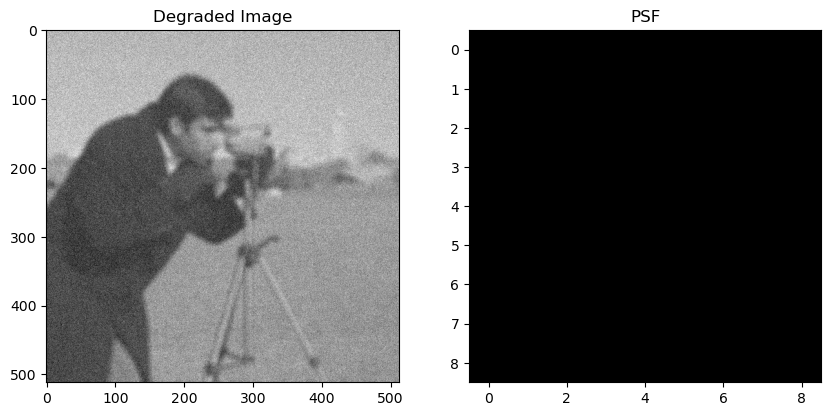

In [7]:
from skimage.data import camera
original_image = camera().astype(np.float32) / 255.0
degraded_image, psf = degrade_image(original_image, psf_size=9, noise_var=0.01)

# Display degraded image and PSF
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.title("Degraded Image"), plt.imshow(degraded_image, cmap='gray')
plt.subplot(1, 2, 2), plt.title("PSF"), plt.imshow(psf, cmap='gray')
plt.show()


Application

Iteration 1/50...
Step 1 completed.
Step 2 completed.
Iteration 2/50...
Step 1 completed.
Step 2 completed.
Iteration 3/50...
Step 1 completed.
Step 2 completed.
Iteration 4/50...
Step 1 completed.
Step 2 completed.
Iteration 5/50...
Step 1 completed.
Step 2 completed.
Iteration 6/50...
Step 1 completed.
Step 2 completed.
Iteration 7/50...
Step 1 completed.
Step 2 completed.
Iteration 8/50...
Step 1 completed.
Step 2 completed.
Iteration 9/50...
Step 1 completed.
Step 2 completed.
Iteration 10/50...
Step 1 completed.
Step 2 completed.
Iteration 11/50...
Step 1 completed.
Step 2 completed.
Iteration 12/50...
Step 1 completed.
Step 2 completed.
Iteration 13/50...
Step 1 completed.
Step 2 completed.
Iteration 14/50...
Step 1 completed.
Step 2 completed.
Iteration 15/50...
Step 1 completed.
Step 2 completed.
Iteration 16/50...
Step 1 completed.
Step 2 completed.
Iteration 17/50...
Step 1 completed.
Step 2 completed.
Iteration 18/50...
Step 1 completed.
Step 2 completed.
Iteration 19/50...


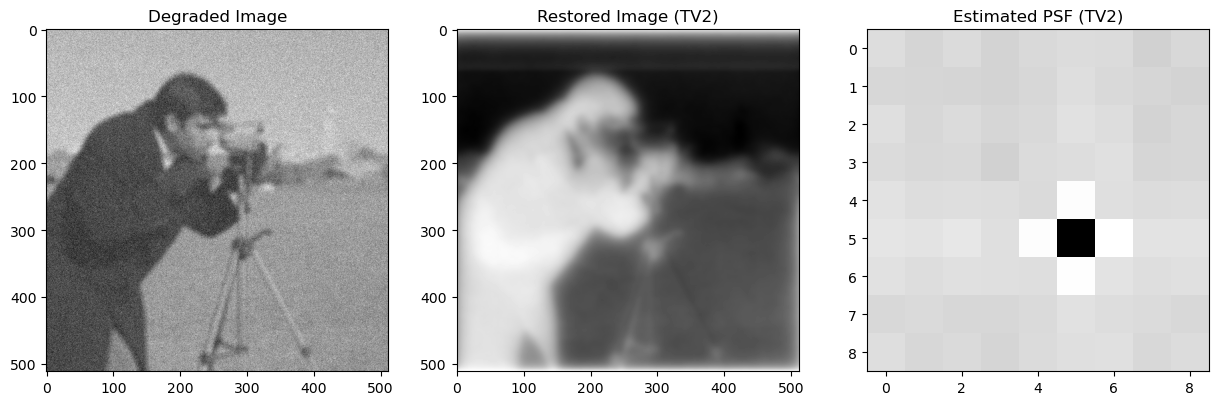

In [8]:
restored_tv2, estimated_psf_tv2 = tv2_algorithm(
    degraded_image,
    psf,
    max_iter=50,
    reg_param=1e-2,
    gamma=1e-2
)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.title("Degraded Image"), plt.imshow(degraded_image, cmap='gray')
plt.subplot(1, 3, 2), plt.title("Restored Image (TV2)"), plt.imshow(restored_tv2, cmap='gray')
plt.subplot(1, 3, 3), plt.title("Estimated PSF (TV2)"), plt.imshow(estimated_psf_tv2, cmap='gray')
plt.show()


ISNR calculation

In [9]:
def calculate_isnr(original, degraded, restored):
    num = np.sum((original - degraded) ** 2)
    den = np.sum((original - restored) ** 2)
    return 10 * np.log10(num / den)

isnr_tv2 = calculate_isnr(original_image, degraded_image, restored_tv2)
print(f"ISNR (TV2): {isnr_tv2:.2f} dB")


ISNR (TV2): -93.93 dB
